In [54]:
import networkx as nx
import pandas as pd
from scipy import stats
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from functions import load_graph_1, load_graph_2, top_N_filter

graph1 = load_graph_1()
graph2 = load_graph_2()
plt.set_cmap('Set2')
set2_cmap = get_cmap('Set2')

<Figure size 640x480 with 0 Axes>

## Functionality and Viz 1

In [51]:
def func1(graph, type, N=-1):
    graph = top_N_filter(graph, N)
    
    node_number = len(graph)
    if type==1:
        collab = dict(graph.degree)
    elif type==2:
        collab = dict(filter(lambda k: graph.nodes[k[0]]['type'] == 'comic', dict(graph.degree).items()))
    
    density = nx.density(graph)
    
    degree_count = Counter(dict(graph.degree).values())
    probs = np.array(list(degree_count.values()))/sum(degree_count.values())
    values = np.array(list(degree_count.keys()))
    pmf = stats.rv_discrete(name='degree', values=(values, probs))
    avg = pmf.mean()
    
    p95 = pmf.ppf(.95)
    hubs = [n for n,v in graph.degree if v >= p95]
    
    is_dense = density > 0.05
    
    return node_number, collab, density, pmf, avg, hubs, is_dense

In [61]:
def viz1(graph, type, N=-1):
    node_number, collab, density, pmf, avg, hubs, is_dense = func1(graph, type, N)
    
    # print table
    print( '| Number of nodes | Density | Average degree | Is dense |')
    print( '|-----------------|---------|----------------|----------|')
    print(f'| {node_number:15} | {round(density, 3):7} | {round(avg, 3):14} | {"True" if is_dense else "False":8} |')
    
    display(pd.DataFrame(hubs, columns=['Hubs']))
    
    # A plot depicting the number of collaborations of each hero
    c = pd.DataFrame.from_dict(collab, orient='index').sort_values(by=0, ascending=False)
    plt.bar(x = c.index, height = c[0], color=set2_cmap(0))
    if type == 2:
        plt.title('# of heroes per comic')
    elif type==1:
        plt.title('# of collaborations per hero')
    if len(c) > 10:
        plt.xticks([])
    plt.show()
    
    # A plot depicting the degree distribution of the network
    xk = range(*pmf.support())
    print(xk)
    plt.title('Graph degree distribution')
    plt.vlines(xk, 0, pmf.pmf(xk), lw=3)
    plt.show()

Viz1 for graph #1

| Number of nodes | Density | Average degree | Is dense |
|-----------------|---------|----------------|----------|
|            1000 |   0.123 |        123.136 | True     |


,Hubs
0,ANGEL/WARREN KENNETH
1,ANT-MAN/DR. HENRY J.
2,BEAST/HENRY &HANK& P
3,BLACK KNIGHT V/DANE
4,BLACK PANTHER/T'CHAL
5,BLACK WIDOW/NATASHA
6,"CAGE, LUKE/CARL LUCA"
7,CAPTAIN AMERICA
8,COLOSSUS II/PETER RA
9,CRYSTAL [INHUMAN]


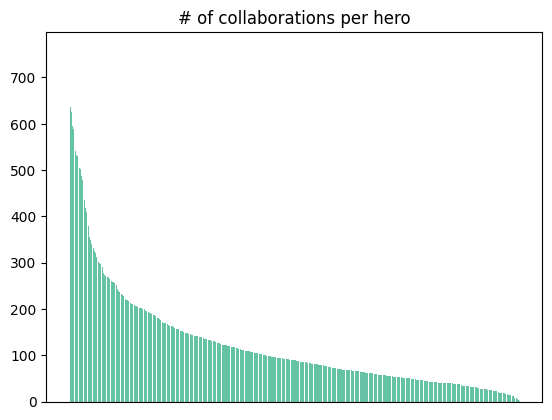

range(2, 760)


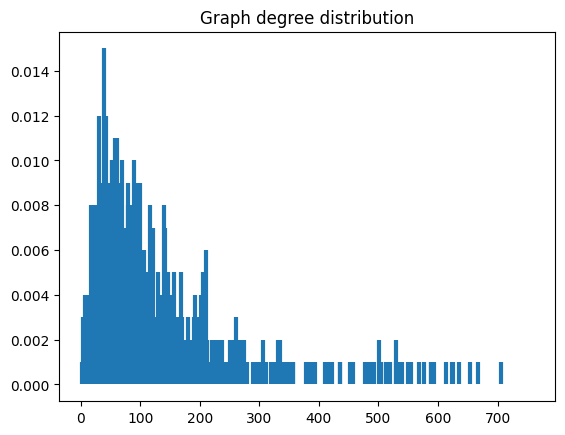

In [62]:
viz1(graph1, 1, 1000)

| Number of nodes | Density | Average degree | Is dense |
|-----------------|---------|----------------|----------|
|           13367 |   0.001 |         11.355 | False    |


,Hubs
0,COC 1
1,ABOMINATION/EMIL BLO
2,H2 278
3,SWII 7
4,ABSORBING MAN/CARL C
...,...
683,X-MAN/NATHAN GREY
684,YELLOW CLAW/TZING JA
685,ZABU
686,"ZARRKO, ARTHUR"


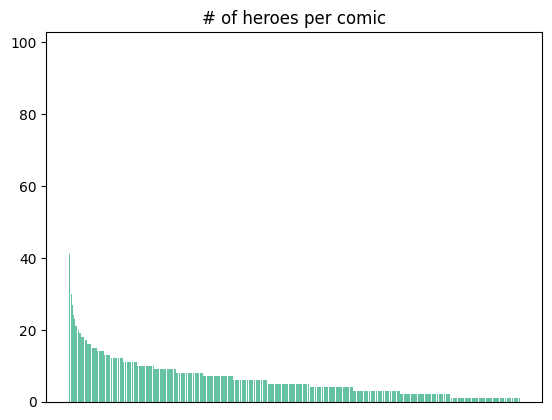

range(1, 1577)


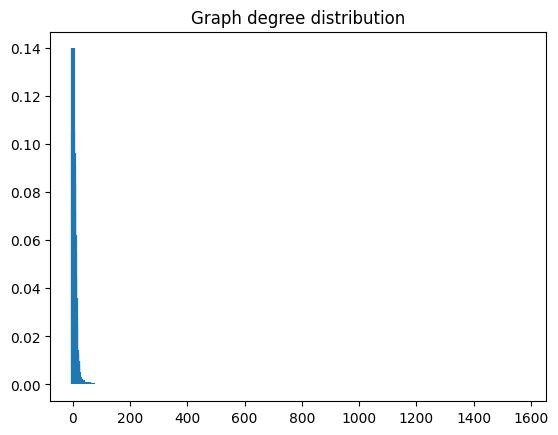

In [63]:
viz1(graph2, 2, 1000)

## Functionality and Viz 5

In [66]:
def func5(graph, hero1, hero2, N=-1, k=2):
    '''K: number of comunities'''
    graph = top_N_filter(graph, N)
    
    cc = nx.number_connected_components(graph)
    removed_edges = 0
    while cc < k:
        edges_to_remove = most_ebc(graph)
        graph.remove_edges_from(edges_to_remove)
        if cc == 1:
            removed_edges += len(edges_to_remove)
        cc = nx.number_connected_components(graph)
        
    cc = list(nx.connected_components(graph))
    
    same_community = any([hero1 in community and hero2 in community for community in cc])
        
    return removed_edges, cc, same_community
    
def most_ebc(graph):
    '''Selects all edges which have maximum ebc'''
    ebc = nx.edge_betweenness_centrality(graph)
    M = max(ebc.values())
    edges = list(filter(lambda a: ebc[a] == M, ebc.keys()))
    return edges
    
    
func5(graph1, 'CAPTAIN AMERICA','IRON MAN/TONY STARK', N=100)

(40,
 [{'ANGEL/WARREN KENNETH',
   'ANT-MAN/DR. HENRY J.',
   'BALDER [ASGARDIAN]',
   'BANNER, BETTY ROSS T',
   'BANSHEE/SEAN CASSIDY',
   'BEAST/HENRY &HANK& P',
   'BINARY/CAROL DANVERS',
   'BLACK KNIGHT V/DANE',
   "BLACK PANTHER/T'CHAL",
   'BLACK WIDOW/NATASHA',
   'BOOMER/TABITHA SMITH',
   'CAGE, LUKE/CARL LUCA',
   'CANNONBALL II/SAM GU',
   'CAPTAIN AMERICA',
   'CAPTAIN BRITAIN/BRIA',
   'CAPTAIN MARVEL II/MO',
   'CLEA',
   'COLOSSUS II/PETER RA',
   'CRYSTAL [INHUMAN]',
   'CYCLOPS/SCOTT SUMMER',
   'DAREDEVIL/MATT MURDO',
   'DR. DOOM/VICTOR VON',
   'DR. STRANGE/STEPHEN',
   'DUGAN, TIMOTHY ALOYI',
   'FALCON/SAM WILSON',
   'FANDRAL [ASGARDIAN]',
   'FURY, COL. NICHOLAS',
   'GAMBIT/REMY LEBEAU',
   'HAVOK/ALEX SUMMERS',
   'HAWK',
   'HERCULES [GREEK GOD]',
   'HOGUN [ASGARDIAN]',
   'HUDSON, HEATHER',
   'HULK/DR. ROBERT BRUC',
   'HUMAN TORCH/JOHNNY S',
   'ICEMAN/ROBERT BOBBY',
   'INVISIBLE WOMAN/SUE',
   'IRON FIST/DANIEL RAN',
   'IRON MAN IV/JAMES R.',
   'IRO

Minimum number of links to be removed: 5


Communities:


,0,1,2,3,4
0,0,10,20,32,40
1,1,11,21,33,41
2,2,12,22,34,42
3,3,13,23,35,43
4,4,14,24,36,44
5,5,15,25,37,45
6,6,16,26,38,46
7,7,17,27,39,47
8,8,18,28,30,48
9,9,19,29,31,49


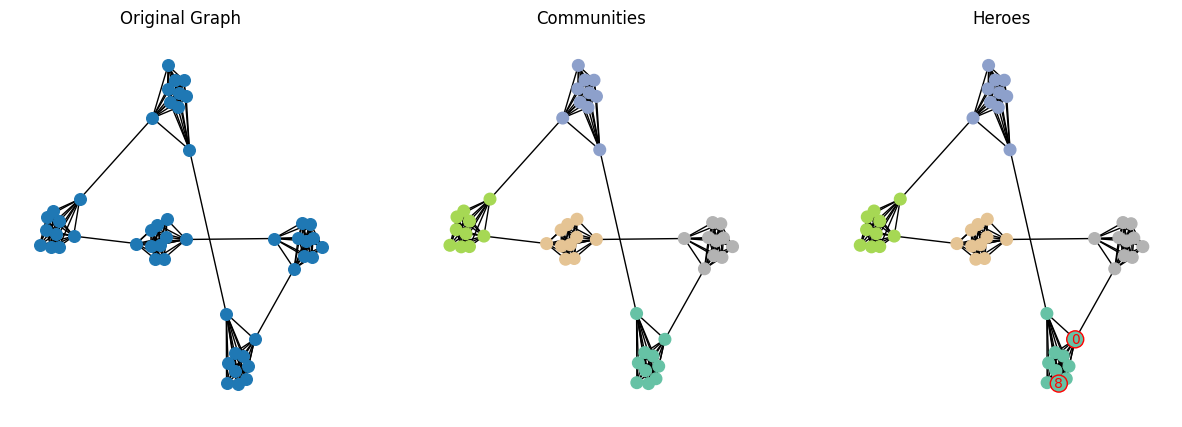

In [71]:
def viz5(graph, hero1, hero2, N=-1):
    removed_edges, cc, same_community = func5(graph, hero1, hero2, N)
    graph = top_N_filter(graph, N)
    
    print('Minimum number of links to be removed:', removed_edges)
    max_len = max(map(len, cc))
    communities = {i:list(c) + (max_len - len(c)) * [pd.NA] for i,c in enumerate(cc)}
    
    print('\n\nCommunities:')
    display(pd.DataFrame(communities))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches((15,5))
    
    # Plot the original graph
    layout = nx.spring_layout(graph)
    ax1.set_title('Original Graph')
    nx.draw(graph, layout, ax=ax1, node_size=70)
    
    # Plot the graph showing the communities in the network
    color_dict = {n:np.nonzero(list(map(lambda c: n in c, cc)))[0][0] for n in graph.nodes}  
    color_map = list(color_dict.values())
    ax2.set_title('Communities')
    nx.draw(graph, layout, node_color=color_map, ax=ax2, node_size=70)
    
    # Plot the final graph and identify the community/communities of Hero_1 and Hero_2
    labels = {hero1:hero1, hero2:hero2}
    ax3.set_title('Heroes')
    nx.draw(graph,layout, node_color=color_map, ax=ax3, node_size=70)
    nx.draw_networkx_nodes(graph, layout, nodelist=labels.keys(), node_color=[color_dict[hero1], color_dict[hero2]], node_size=150, edgecolors='r')
    nx.draw_networkx_labels(graph,layout,labels,font_size=10,font_color='r', ax=ax3)
    
    plt.show()

viz5(nx.connected_caveman_graph(5,10), 0, 8)

Viz 5 final output

Minimum number of links to be removed: 0


Communities:


,0,1,2,3
0,TUVO,SWORDSMAN IV,"ASHER, DONNA",MASTER OF VENGEANCE
1,"GREEN, ARNIE","DARLEGUNG, GEN.",ORWELL,STEEL SPIDER/OLLIE O
2,"SENNET, PAMELA",MANT/ERNEST,"LUDLUM, ROSS",<NA>
3,"STERN, ROGER",STERLING,"NILES, SEN. CATHERIN",<NA>
4,BERNARD THE POET,AMAZO-MAXI-WOMAN,"ASHER, CARL",<NA>
...,...,...,...,...
6397,APE MAN II/ROY MCVEY,<NA>,<NA>,<NA>
6398,"AYALA, MRS.",<NA>,<NA>,<NA>
6399,PROCTOR,<NA>,<NA>,<NA>
6400,HO TI,<NA>,<NA>,<NA>


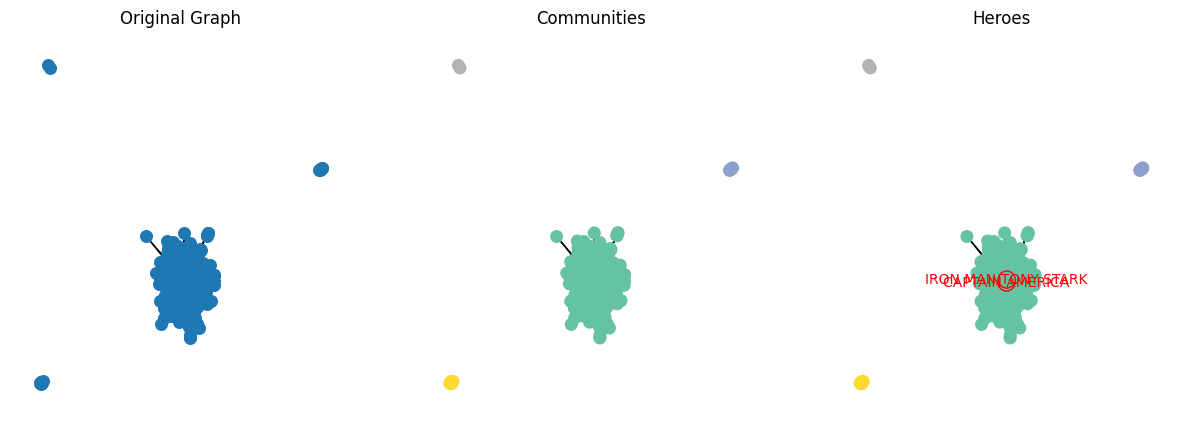

In [72]:
viz5(graph1, 'CAPTAIN AMERICA','IRON MAN/TONY STARK')

# Bonus


In [30]:
k = 1000
l = int(np.sqrt(k))
beta = 0.85
M = nx.adjacency_matrix(graph1)
M /= M.sum(axis=1)
n = M.shape[0]
q = np.ones((n,1)) * 1/n
blocksize = int(n // l)

In [31]:
# We divide M into l row blocks
blocks = {i//blocksize:M[i:i+blocksize] for i in range(0, n, blocksize)}

for t in range(0,80):
    q_blocks = {i//blocksize: q[i:i+blocksize] for i in range(0,n,blocksize)}

    # Mapper
    mapped = map(lambda i: blocks[i].T @ q_blocks[i], range(0,l))
    
    # Reducer
    q = np.sum(list(mapped), axis=0) * beta + (1-beta)/n

ranks = list(np.array(list(graph1.nodes))[q.reshape(-1).argsort()[::-1]])

In [32]:
print("Top 10 most important super heroes:")
ranks[:10]

Top 10 most important super heroes:


['SPIDER-MAN/PETER PAR',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'WOLVERINE/LOGAN',
 'THING/BENJAMIN J. GR',
 'MR. FANTASTIC/REED R',
 'HUMAN TORCH/JOHNNY S',
 'SCARLET WITCH/WANDA',
 'THOR/DR. DONALD BLAK',
 'BEAST/HENRY &HANK& P']